# Analyze the gamma rule

## Empirical analysis of LRP-$\gamma$'s forward surrogate model

We now analyse the Eigenvalues of the LRP-$\gamma$'s forward surrogate model for the following cases:

- a random 3x3 matrix
    - with random 3-dimensional input
- a random 784x784 matrix 
    - with random 784-dimensional input
- a 784x784 matrix that represents a learned convolution operation: It performs the global transition from a (flattened) MNIST picture, to a first layer hidden representation of a convolutional network (before nonlinearities)
    - with an MNIST picture, flattened to a 784-dimensional vector
    - with random 784-dimensional input

#### Loading stuff

In [1]:
%load_ext autoreload
%autoreload 2

import torch
from util.util_cnn import get_test_loader, CNN, test
device = "cpu"
PATH = './models/mnist_cnn.torch'

from util.util_gamma_rule import forw_surrogate_matrix, forw_surrogate_matrix_sparse, calc_evals_batch, plot_evals_lineplot, global_conv_matrix

import numpy as np
import matplotlib.pyplot as plt

# vgg experiments
import cv2
import torchvision


# lrp-tutorial sub repo
from lrp_tutorial import utils as montavon_util

/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


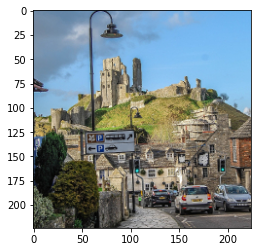

In [2]:
img = np.array(cv2.imread('lrp_tutorial/castle.jpg'))[...,::-1]/255.0
plt.imshow(img)

In [3]:
mean = torch.Tensor([0.485, 0.456, 0.406]).reshape(1,-1,1,1)
std  = torch.Tensor([0.229, 0.224, 0.225]).reshape(1,-1,1,1)

X = (torch.FloatTensor(img[None].transpose([0,3,1,2])*1) - mean) / std

In [4]:
vgg = torchvision.models.vgg16(pretrained=True); vgg.eval()
layers = list(vgg._modules['features']) + montavon_util.toconv(list(vgg._modules['classifier']))
L = len(layers)

/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/Users/johannes/Applications/miniconda3/envs/msc/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [5]:
A = [X]+[None]*L
for l in range(L): A[l+1] = layers[l].forward(A[l])

In [6]:
scores = np.array(A[-1].data.view(-1))
ind = np.argsort(-scores)
for i in ind[:10]:
    print('%20s (%3d): %6.3f'%(montavon_util.imgclasses[i][:20],i,scores[i]))

              castle (483): 11.029
church, church build (497):  9.522
           monastery (663):  9.401
 bell cote, bell cot (442):  9.047
cinema, movie theate (498):  8.016
        analog clock (409):  7.109
         street sign (919):  7.103
traffic light, traff (920):  7.058
thatch, thatched roo (853):  6.978
                 alp (970):  6.812


In [7]:
print("NOTE: we only look at one convolutional filter (of 64) of the first layer, and we only look at ONE COLOR CHANNEL (of three that the conv filter is using)!")
print(layers[0].weight.detach().numpy().shape)
print(layers[0].weight.detach().numpy()[0,0].shape)

NOTE: we only look at one convolutional filter (of 64) of the first layer, and we only look at ONE COLOR CHANNEL (of three that the conv filter is using)!
(64, 3, 3, 3)
(3, 3)


In [8]:
def global_conv_matrix_from_pytorch_layer(layer, img_shape, filter_no):
    conv = layer.weight.detach()[filter_no, 0]      # TODO: we only look at one color channel of the convolutional filter so far.
    bias = layer.bias.detach().numpy()[0]           # TODO: we don't factor in biases so far.
    padd = layer.padding

    trans = global_conv_matrix(conv, bias,
                                img_shape=img_shape,
                                zero_padding=padd,
                                sparse_matrix=True) # using a sparse matrix reduces the funciton runtime by many orders of magnitude

    return trans

color_channel_one = A[0][0, 0].detach() # from the first batch, take only the first image, take only the first color channel.
trans = global_conv_matrix_from_pytorch_layer(layers[0], color_channel_one.shape, filter_no=0)
trans.shape

torch.Size([50176, 50176])

In [32]:
X.shape

torch.Size([1, 3, 224, 224])

In [ ]:
conv = layers[0].weight.detach().numpy()[0,0]
bias = layers[0].bias.detach().numpy()[0]
padd = layers[0].padding

color_channel_one = X[0, 0] # from the first batch, take only the first image, take only the first color channel.

trans_dense = global_conv_matrix(conv, bias,
                            img_shape=color_channel_one.shape,
                            zero_padding=padd,
                            sparse_matrix=False) # this is VERY SLOW

trans_dense.shape

(50176, 50176)

#### Lets express a single (learned) convolutional filter in the form of a global transition matrix

- input dimension is 28x28 = 784
- output dimension is 24x24 = 576
- transition matrix shape is (576, 784)
- (no padding is used)

input: torch.Size([224, 224])


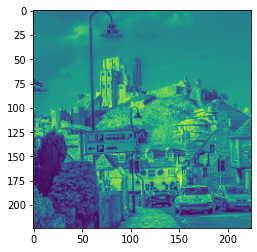

NameError: name 'conv' is not defined

In [9]:
print(f'input: {color_channel_one.shape}')
plt.imshow(color_channel_one)
plt.show()

conv_layer = torch.nn.Conv2d(1,1,3,padding=(1,1), bias=False)
with torch.no_grad():
    conv_layer.weight.copy_(conv)

out_org = conv_layer(color_channel_one.view((-1, *(color_channel_one.shape))))[0].detach().numpy()
print(f'output: {out_org.shape}')
plt.colorbar(plt.imshow(out_org));

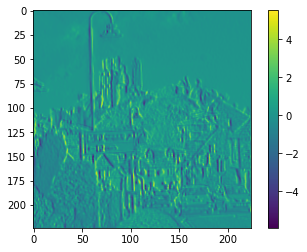

In [ ]:
# check that the transition matrix gives the same result as the convolution operation;
out = trans @ color_channel_one.flatten()
out = out.reshape(color_channel_one.shape)
plt.colorbar(plt.imshow(out))
assert(np.allclose(out, out_org, atol=0.00001))

#### Simple analysis of trans

### [Learned Convolution Matrix, Random Matrix] - Random points

#### Findings

- learned weights only have 24 non-zero Eigenvalues.
- EV of random matrix change much more erratic than those of the learned weights.

In [10]:
x_indices, y_indices = trans.coalesce().indices()
row_index, vals_in_row = y_indices.unique(return_counts=True)

vals_per_row, number_of_rows = vals_in_row.unique(return_counts=True)
for val_per_row, num_of_rows in zip(vals_per_row, number_of_rows):
    print(f"There are {num_of_rows:5} rows with {val_per_row} values in them.")

There are     4 rows with 4 values in them.
There are   888 rows with 6 values in them.
There are 49284 rows with 9 values in them.


In [11]:
color_channel_one.shape

torch.Size([224, 224])

visualizing a small section in the top left of trans:


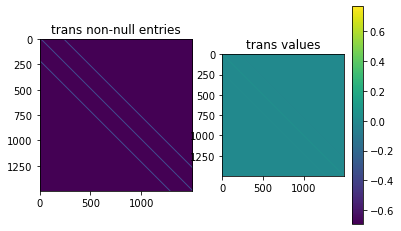

In [12]:
print("visualizing a small section in the top left of trans:")

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.imshow(trans.to_dense()[:1500, :1500] != 0)
plt.colorbar(ax2.imshow(trans.to_dense()[:1500, :1500]))

ax1.set_title("trans non-null entries")
ax2.set_title("trans values");

### Run trans on real input

[0.   0.04 0.08 0.12 0.16 0.2  0.24 0.28 0.32 0.36 0.4 ]
Running with at least one sparse matrix...


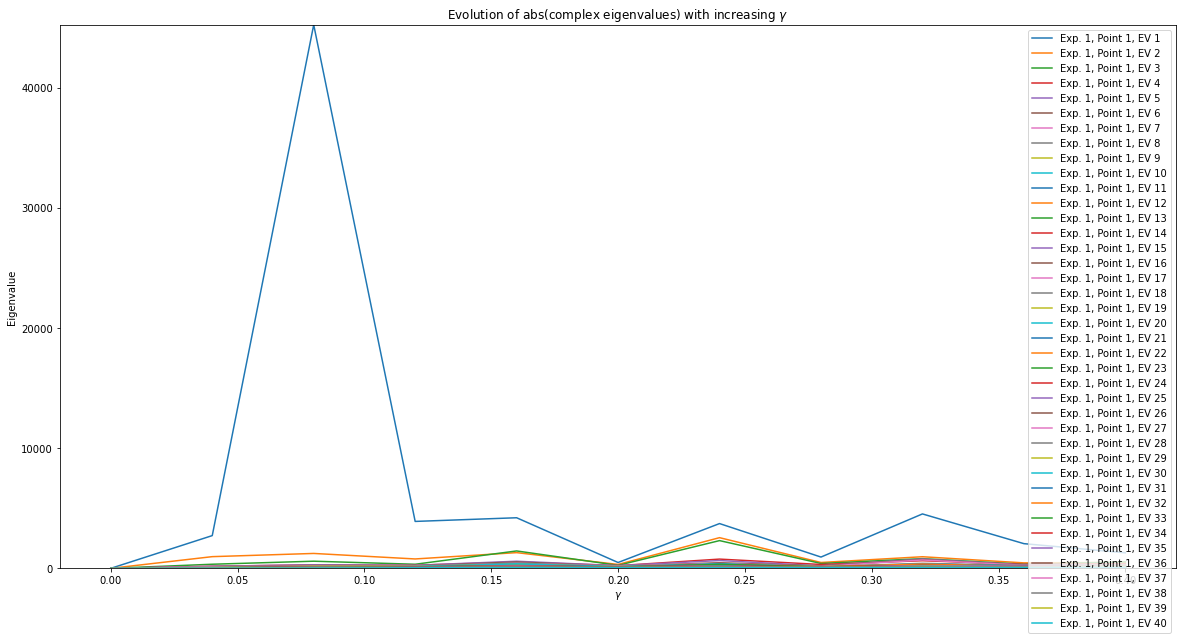

In [15]:
gammas = np.linspace(0, 0.4, 11)
print(gammas)

computed_evals = calc_evals_batch([trans], [color_channel_one.flatten()], gammas=gammas, num_evals=40)
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=100)

In [ ]:
gammas = np.linspace(0, 0.4, 101)
print(gammas)

computed_evals = calc_evals_batch([trans], [color_channel_one.flatten()], gammas=gammas, num_evals=40)

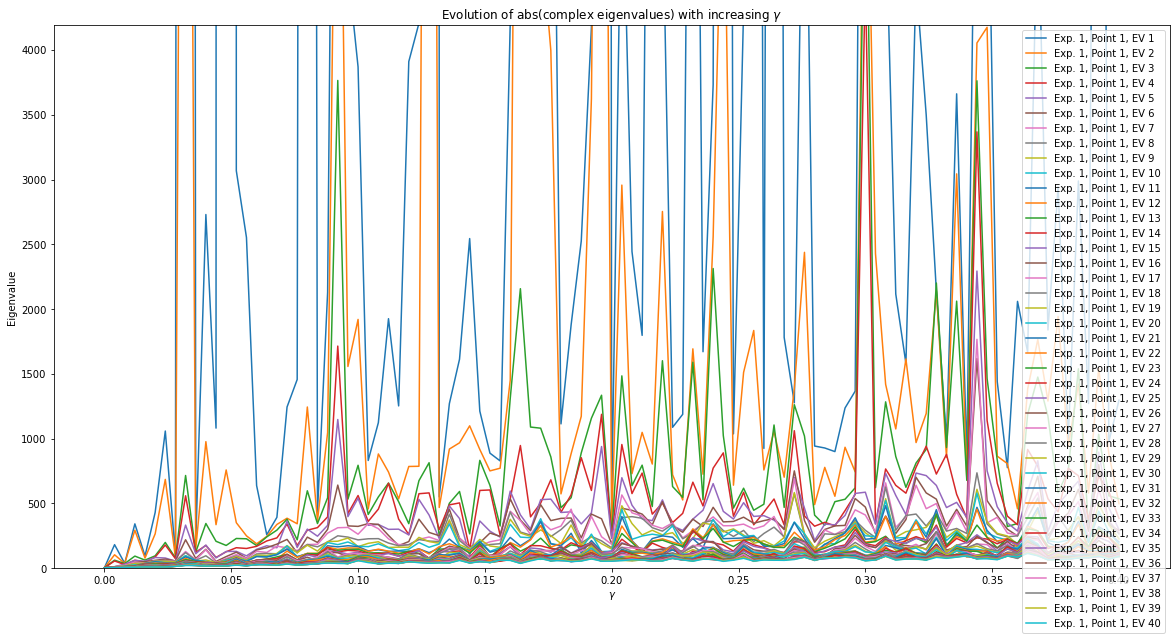

In [17]:
plot_evals_lineplot(computed_evals, gammas, mark_positive_slope=False, percentile_to_plot=99)

In [20]:
np.array(computed_evals).shape

(1, 1, 101, 40)

In [21]:
trans_matrices = [global_conv_matrix_from_pytorch_layer(layers[0], color_channel_one.shape, filter_no=i) for i in range(8)]

In [25]:
gammas = np.linspace(0, 1, 21)
print(gammas)

computed_evals_multiple_filters = calc_evals_batch(trans_matrices, [color_channel_one.flatten()], gammas=gammas, num_evals=40)

[0.   0.05 0.1  0.15 0.2  0.25 0.3  0.35 0.4  0.45 0.5  0.55 0.6  0.65
 0.7  0.75 0.8  0.85 0.9  0.95 1.  ]
Running with at least one sparse matrix...


In [28]:
len(computed_evals_multiple_filters), len(computed_evals_multiple_filters[0]), len(computed_evals_multiple_filters[0][0])

(8, 1, 21)

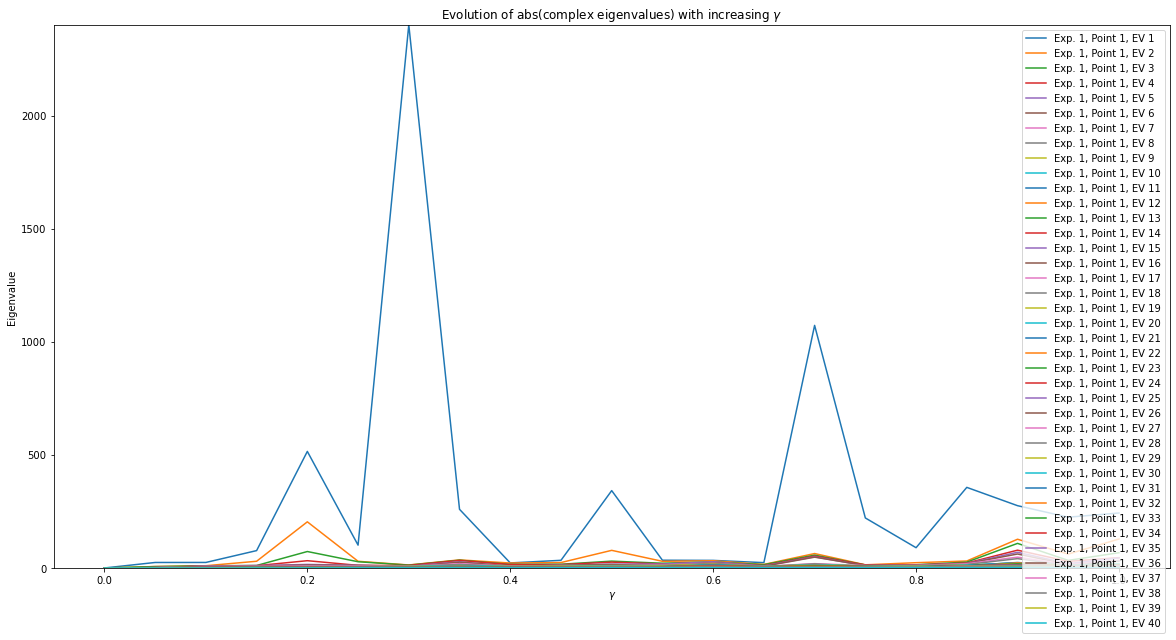

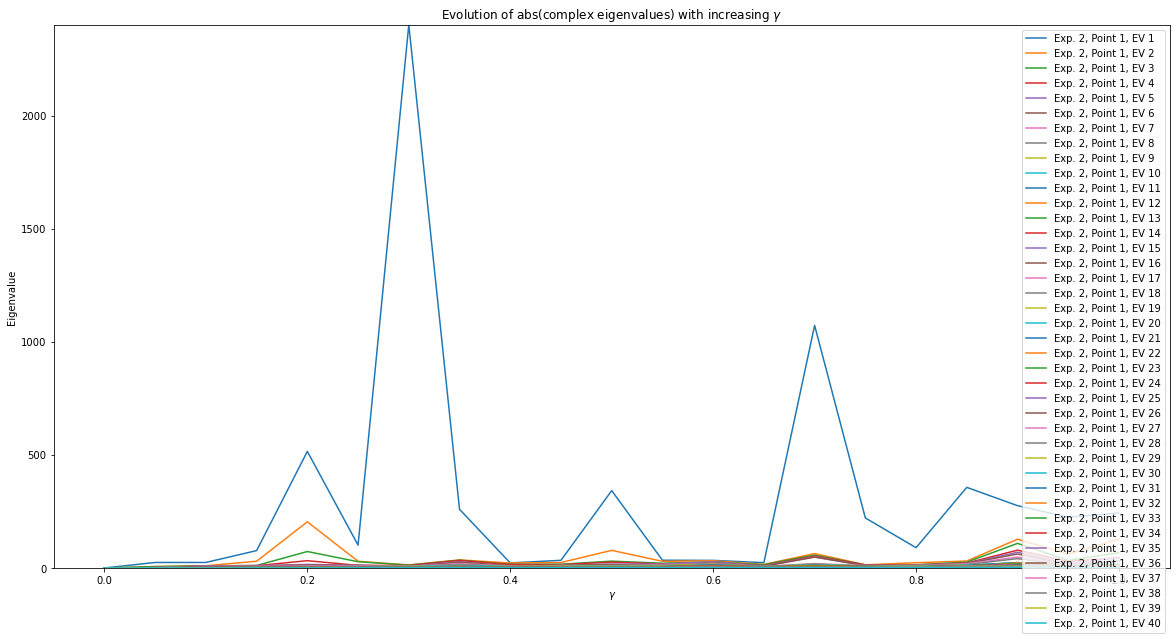

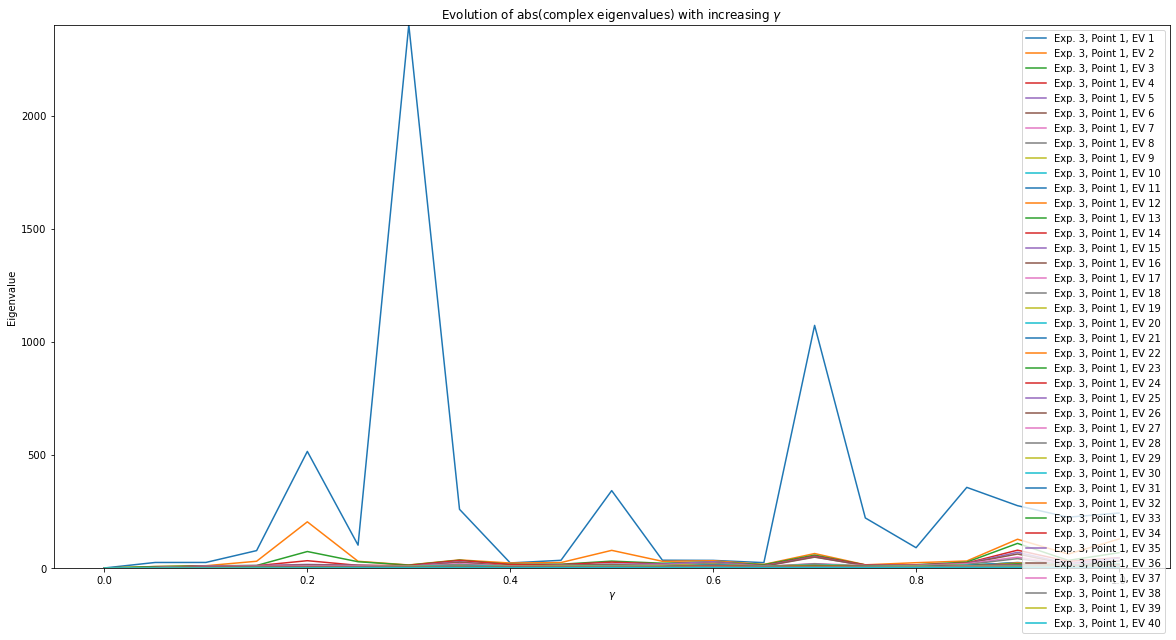

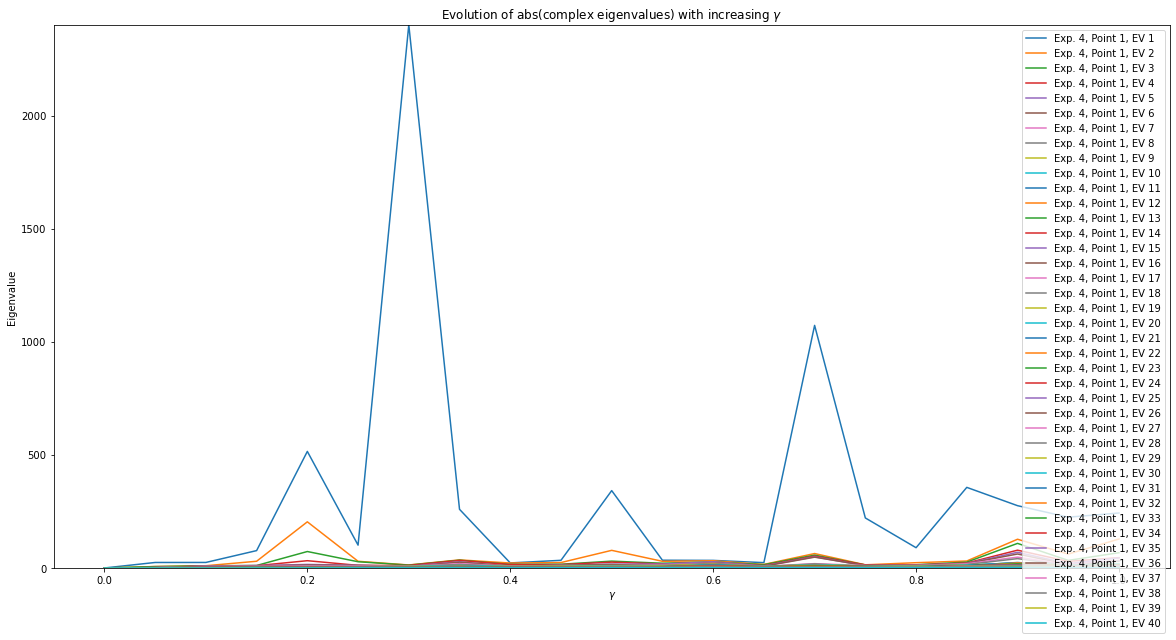

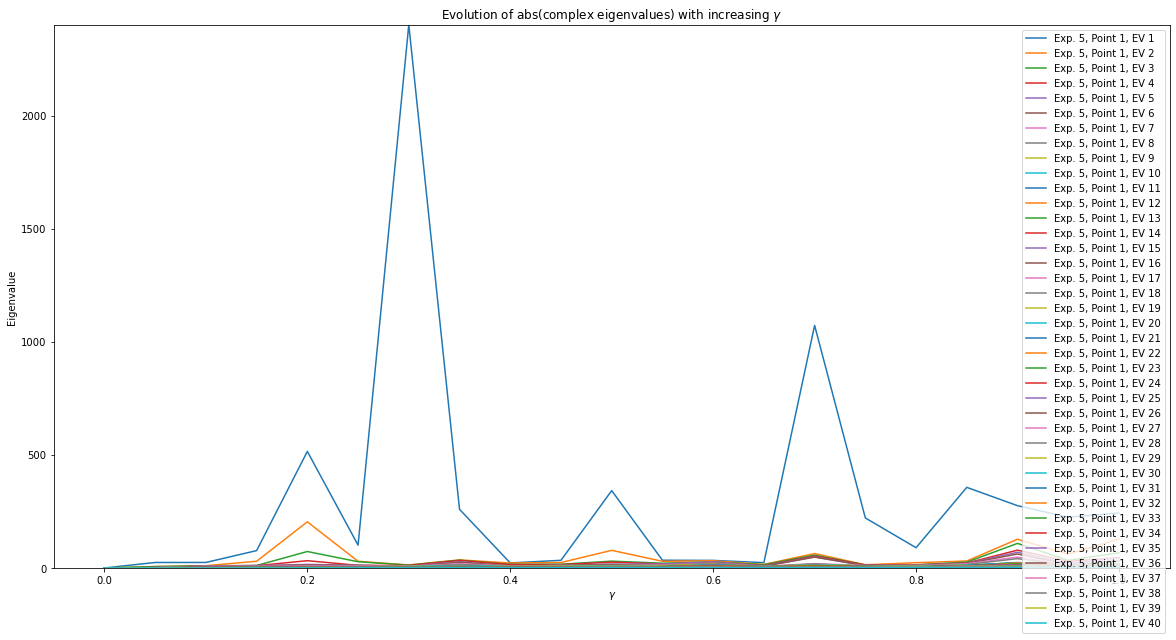

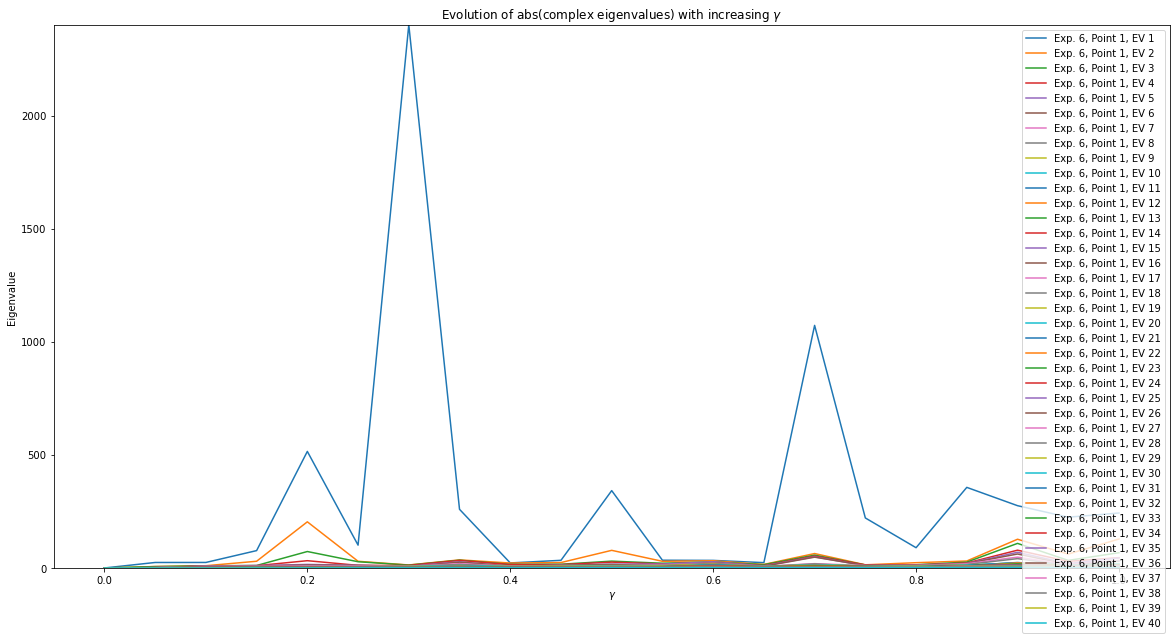

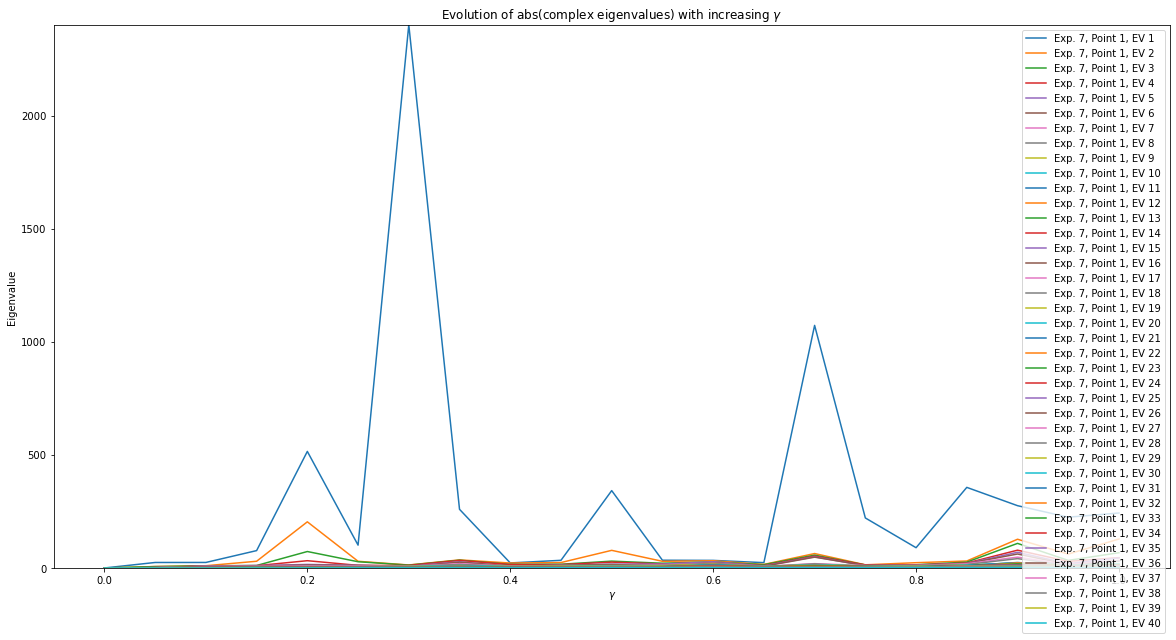

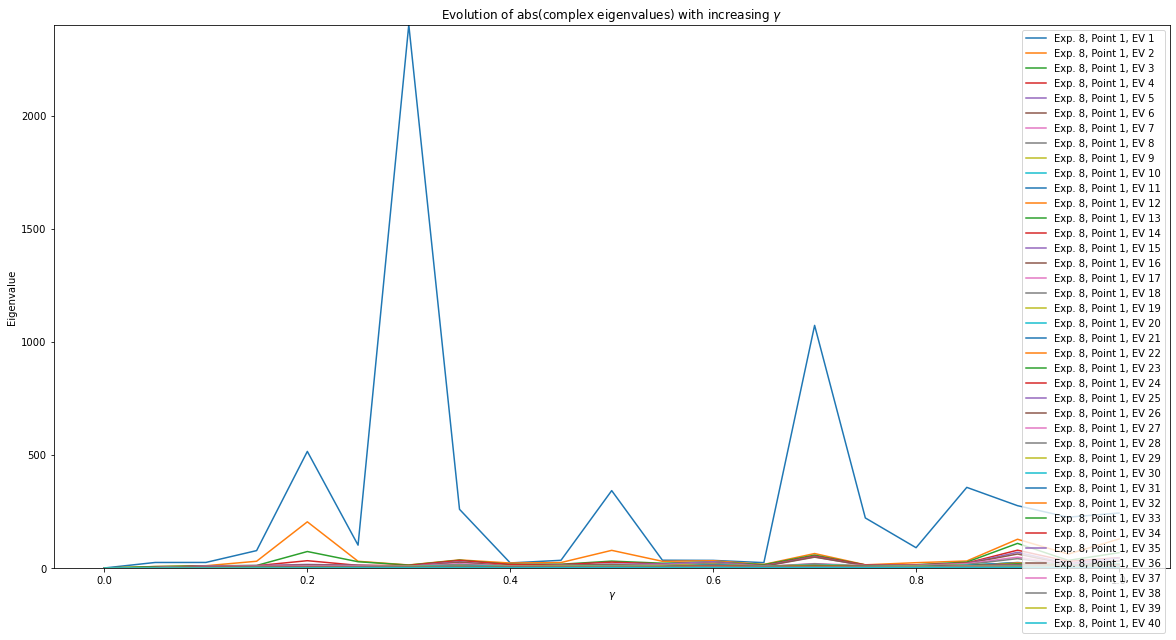

In [26]:
plot_evals_lineplot(computed_evals_multiple_filters, gammas=gammas, mark_positive_slope=False, percentile_to_plot=100)

#### EV plot

In [29]:
trans_matrices[:1]

[tensor(indices=tensor([[  225,   226,   227,  ..., 49948, 49949, 49950],
                        [    0,     1,     2,  ..., 50173, 50174, 50175]]),
        values=tensor([-0.5537, -0.5537, -0.5537,  ...,  0.4841,  0.4841,
                        0.4841]),
        size=(50176, 50176), nnz=448900, layout=torch.sparse_coo)]

In [40]:
gammas = np.linspace(0, 1, 21)
print(gammas)

computed_evals_multiple_filters = calc_evals_batch(trans_matrices[:1], [color_channel_one.flatten()], gammas=gammas, num_evals=40)